In [85]:
import matplotlib.pyplot as plt

import numpy as np 
from numpy import sin, cos


from pydrake.common.value import Value
from pydrake.systems.framework import DiagramBuilder, LeafSystem, BasicVector
from pydrake.systems.primitives import LogVectorOutput
from pydrake.systems.framework import Context, ContinuousState, SystemOutput

#from pydrake.multibody.math import SpatialForce
#from pydrake.multibody.plant import AddMultibodyPlantSceneGraph, ExternallyAppliedSpatialForce, ExternallyAppliedSpatialForceMultiplexer
#from pydrake.multibody.parsing import Parser
from pydrake.all import Simulator, ConstantVectorSource



In [126]:


class PlanarPRR_continuous(LeafSystem):

    def __init__(self):

        LeafSystem.__init__(self)

        self.M = np.zeros((3, 3))
        self.C = np.zeros((3))
        self.ActuationMatrix = np.zeros((3, 2))

        # def joint limit: 
        self.limit_q1 = 12
        self.limit_q2 = np.pi
        self.limit_q3 = np.pi

        self.DeclareContinuousState(6)
        self.DeclareVectorInputPort("F", BasicVector(2))

        self.DeclareVectorOutputPort("state", BasicVector(6), self.CalcStateOut)
        self.DeclareVectorOutputPort("end-effector_posit", BasicVector(2), self.CalcEndEffectorPosition)
        
        self.init_dynamic_model_parameters()

    def DoCalcTimeDerivatives(self, context:Context, derivatives_out:ContinuousState):

        fx, fy = self.get_input_port(0).Eval(context)
        F = np.array([fx, fy])
        state = context.get_continuous_state_vector()

        # test on fixing joint limit. Still to do: this next lines doesn't work
        dq1 = min(max(state[3], -self.limit_q1), self.limit_q1)
        dq2 = min(max(state[4], -self.limit_q2), self.limit_q2)
        dq3 = min(max(state[5], -self.limit_q3), self.limit_q3)

        self.eval_dyn_model(state_vect=state)
        #q_dot = np.array([state[3], state[4], state[5]])
        q_dot = np.array([dq1, dq2, dq3])
        q_dot_dot = np.linalg.inv(self.M) @ ((self.ActuationMatrix @ F) - self.C)
        derivatives = np.concatenate( (q_dot, q_dot_dot) )
        derivatives_out.get_mutable_vector().SetFromVector(derivatives)

    def init_dynamic_model_parameters(self):

        self.m = [1, 1, 1]
        self.I = [1, 1, 1]
        self.d = [None, 0.5, 0.5]
        self.l = [None, 1, 1]  # the first is none because is q1
        
        self.a1 = self.m[0] + self.m[1] + self.m[2]
        self.a2 = self.I[1] + self.m[1] * (self.d[1]**2) + self.m[2]*(self.l[2]**2)
        self.a3 = self.I[2] + self.m[2] * (self.d[2]**2)
        self.a4 = self.m[2] * self.d[2]
        self.a5 = self.m[1] * self.d[1] + self.m[2] * self.l[1]

    def eval_dyn_model(self, state_vect):
        self._eval_M_of_q(state_vect)
        self._eval_C_of_q(state_vect)
        self._eval_actuation_matrix(state_vect)

    def _eval_M_of_q(self, state_vect):

        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]
        
        self.M[0, 0] =  self.a1
        self.M[0, 1] = -self.a5 * sin(q2)  - self.a4 * sin(q2 + q3)
        self.M[0, 2] = -self.a4 * sin(q2 + q3)

        self.M[1, 0] = -self.a5 * sin(q2) - self.a4 * sin(q2 + q3)
        self.M[1, 1] = self.a2 + self.a3 + 2*self.a4 * self.l[1] * cos(q3)
        self.M[1, 2] = self.a3 + self.a4 * self.l[1] * cos(q3)

        self.M[2, 0] = -self.a4 * sin(q2 + q3)
        self.M[2, 1] = self.a3 + self.a4 * self.l[1] * cos(q3)
        self.M[2, 2] = self.a3

    def _eval_C_of_q(self, state_vec):         
    
        q1, q2, q3 = state_vec[0], state_vec[1], state_vec[2]
        dq1, dq2, dq3 = state_vec[3], state_vec[4], state_vec[5]

        self.C[0] = (-self.a5*cos(q2) + self.a4*cos(q2+q3))*(dq2**2) - self.a4*cos(q2+q3)*dq3*(dq2 + dq3)
        self.C[1] = -self.a4 * self.l[1] * sin(q3) * dq3 * (2*dq2 + dq3)
        self.C[2] = self.a4 * self.l[2] * sin(q3) * (dq2**2)

    def _eval_actuation_matrix(self, state_vect):

        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]

        self.ActuationMatrix[0, 0]  = 1
        self.ActuationMatrix[0, 1]  = 0 
        
        self.ActuationMatrix[1, 0] = -self.l[1] * sin(q2) - self.l[2] * sin(q2 + q3)
        self.ActuationMatrix[1, 1] = -self.l[1] * cos(q2) - self.l[2] * cos(q2 + q3)
        
        self.ActuationMatrix[2, 0] = -self.l[1] * sin(q2) 
        self.ActuationMatrix[2, 1] = -self.l[1] * cos(q2)

        self.ActuationMatrix = -self.ActuationMatrix

    def CalcStateOut(self, context: Context, outputs: SystemOutput) -> None:
        state = context.get_continuous_state_vector().CopyToVector()
        outputs.SetFromVector(state)

    def CalcEndEffectorPosition(self, context, end_effector_position):

        state = context.get_continuous_state_vector().CopyToVector()
        q1, q2, q3 = state[0], state[1], state[2]
        x_ee = q1 + self.l[1]*cos(q2) + self.l[2]*cos(q2+q3)
        y_ee = self.l[1]*sin(q2) + self.l[2]*sin(q2+q3)
        print(f"x_ee: {x_ee}, y_ee: {y_ee}")
        end_effector_position.SetFromVector([x_ee, y_ee])

    def _get_output_port_state(self): 
        return self.get_output_port(0)
    
    def _get_output_port_end_effector_posit(self): 
        return self.get_output_port(1)

        


In [124]:
rob = PlanarPRR_continuous()


In [130]:
def plot_log(log_j, log_e):
    plt.figure()
    times = log_j.sample_times()

    q1, q2, q3 = log_j.data()[0].transpose(), log_j.data()[1].transpose(), log_j.data()[2].transpose()
    dq1, dq2, dq3 = log_j.data()[3].transpose(), log_j.data()[4].transpose(), log_j.data()[5].transpose()
    x_ee, y_ee = log_e.data()[0].transpose(), log_e.data()[0].transpose()


    fig, axis = plt.subplots(3, 1)
    axis[0].plot(times, q1, color='red', label='q1')
    axis[0].plot(times, q2, color='green', label='q2')
    axis[0].plot(times, q3, color='blue', label='q3')
    axis[0].legend()

    axis[1].plot(times, dq1, color='red', label='dq1')
    axis[1].plot(times, dq2, color='green', label='dq2')
    axis[1].plot(times, dq3, color='blue', label='dq3')
    axis[1].legend()

    axis[2].plot(x_ee, y_ee)

    plt.show()


x_ee: 11.0, y_ee: 1.0
x_ee: 10.999999983333332, y_ee: 1.0000000799999995
x_ee: 10.99999939999653, y_ee: 1.000002879999462
x_ee: 10.999983980855305, y_ee: 1.0000768796157926
x_ee: 10.999592809993255, y_ee: 1.0019466323895585
x_ee: 10.998412304623828, y_ee: 1.0075022516427887
x_ee: 10.996406448984914, y_ee: 1.0166609821173225
x_ee: 10.993490123615931, y_ee: 1.0294077601234282
x_ee: 10.98954430949799, y_ee: 1.0457192939669013
x_ee: 10.984415791720854, y_ee: 1.0655617802354438
x_ee: 10.977916864985678, y_ee: 1.0888879500396567
x_ee: 10.969825109135721, y_ee: 1.115633433119191
x_ee: 10.959883323469512, y_ee: 1.1457124326220387
x_ee: 10.954270447150828, y_ee: 1.161518440341649
x_ee: 10.948309808481264, y_ee: 1.1769970316563776
x_ee: 10.934343437333458, y_ee: 1.2090775343754387
x_ee: 10.919119679208906, y_ee: 1.2391095290018446
x_ee: 10.902844283234737, y_ee: 1.2670556942650721
x_ee: 10.885717913596514, y_ee: 1.292878015466985
x_ee: 10.864160562428653, y_ee: 1.321198805770907
x_ee: 10.8419733

<Figure size 640x480 with 0 Axes>

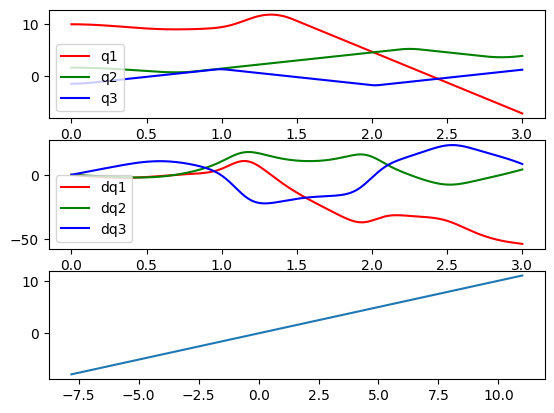

In [131]:
def simulate(simulation_time_step):
    
    builder = DiagramBuilder()
    
    plant = builder.AddSystem(PlanarPRR_continuous())
    logger_joint = LogVectorOutput(plant._get_output_port_state(), builder)
    logger_end_effector = LogVectorOutput(plant._get_output_port_end_effector_posit(), builder)
    stepInput = builder.AddSystem(ConstantVectorSource([20, 0]))
    builder.Connect(stepInput.get_output_port(), plant.get_input_port())
    diagram = builder.Build()
 
    root_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(root_context)
    plant_context.SetContinuousState([10, np.pi/2, -np.pi/2, 0, 0, 0])
     

    simulatore = Simulator(diagram, root_context)
    simulatore.AdvanceTo(simulation_time_step)

    log_joint = logger_joint.FindLog(root_context)
    log_ee = logger_end_effector.FindLog(root_context)
    
    return log_joint, log_ee
    
log_j, log_e = simulate(3.0)
plot_log(log_j, log_e)



In [38]:
builder = DiagramBuilder()
plant = builder.AddSystem(PlanarPRR_continuous())
logger = LogVectorOutput(plant.get_output_port(), builder)
#stepInput = builder.AddSystem(ConstantVectorSource([0, 0]))

    #builder.Connect(stepInput.get_output_port(), plant.get_input_port(0))

diagram = builder.Build()
 
root_context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(root_context)

TypeError: __getitem__(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.systems.framework.VectorBase, arg0: int) -> float

Invoked with: BasicVector([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), (0, 1, 2)

In [30]:
log.sample_times()

array([0.00000000e+00, 1.00000000e-04, 3.40963712e-04, ...,
       9.99944684e+00, 9.99992288e+00, 1.00000000e+01])

In [40]:
from pydrake.systems.primitives import LogVectorOutput

class test_sys(LeafSystem):

    def __init__(self):
        LeafSystem.__init__(self)
        self.DeclareDiscreteState(BasicVector(6))
        self.DeclareVectorOutputPort('state', BasicVector(6), self.copy_state)

    def copy_state(self, context, output):
        x = context.get_discrete_state_vector().CopyToVector()
        x += np.array
        output.SetFromVector(x)


builder = DiagramBuilder()
sys = test_sys()
builder.AddSystem(sys)
logger = LogVectorOutput(sys.get_output_port(0), builder)
diagram = builder.Build()
 
context = diagram.CreateDefaultContext()
sys_context = sys.GetMyContextFromRoot(context)
sys_context.SetDiscreteState(np.zeros(6))



In [41]:
print(sys_context)
simulatore = Simulator(diagram, context)
simulatore.AdvanceTo(4)


::_::__main__.test_sys@000055e2f32dd3a0 Context
------------------------------------------------
Time: 0
States:
  1 discrete state groups with
     6 states
       0 0 0 0 0 0




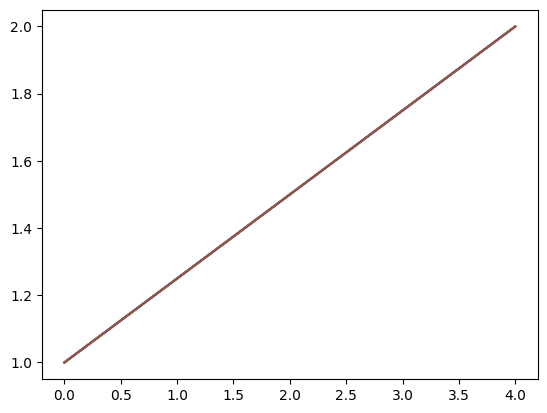

In [42]:
import matplotlib.pyplot as plt

log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(), log.data().transpose())

In [100]:
builder = DiagramBuilder()
    
plant = builder.AddSystem(PlanarPRR())
logger = LogVectorOutput(plant.get_output_port(0), builder)
stepInput = builder.AddSystem(ConstantVectorSource([0.4, 0.4]))

builder.Connect(stepInput.get_output_port(0), plant.get_input_port(0))
diagram = builder.Build()
 
root_context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(root_context)
plant_context.SetDiscreteState(np.array([0,0,0,1,1,1]))